# Introduction

Course: Deep Learing

Author: Oai Tran

Institution: University of Virginia — School of Data Science

Date: 11/07/2025

Notebook Type: Educational / Research — End-to-End Implementation


## Overview
This notebook is the end-to-end process of the final project. The goal of the final project is to predict a stock price and determine whether it is a buy/sell/hold position. 




#### Stage 1

In [1]:
# ==========================================================
#  Stage 1 — META Forecast (v2.6)
#  Δ-Target + Conv1D→LSTM + Macro (VIX) | CuDNN-safe & Merge-Safe
# ==========================================================

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import mplfinance as mpf
import tensorflow as tf
import os
import random
import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model

from datetime import datetime, timedelta


In [2]:

# ----------------------------------------------------------
# 0. Reproducibility & environment setup
# ----------------------------------------------------------
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
os.environ["TF_USE_CUDNN_RNN"] = "0"   # disable CuDNN RNN kernels
print("TensorFlow:", tf.__version__)


TensorFlow: 2.17.0


In [3]:

# ----------------------------------------------------------
# 1. Load data (META + VIX)
# ----------------------------------------------------------
start_date, end_date = "2017-01-01", "2025-09-10"

raw = yf.Ticker("META").history(start=start_date, end=end_date, auto_adjust=False)
vix_raw = yf.Ticker("^VIX").history(start=start_date, end=end_date, auto_adjust=False)

raw = raw[["Open", "High", "Low", "Close", "Volume"]].dropna()
vix_raw = vix_raw[["Close"]].rename(columns={"Close": "VIX_Close"}).dropna()

# ----------------------------------------------------------
# 1.5 Align and clean data
# ----------------------------------------------------------
# Outer join → keep all dates; forward-fill VIX; drop non-trading days for VOO
df = raw.join(vix_raw, how="outer").sort_index()
df["VIX_Close"] = df["VIX_Close"].fillna(method="ffill")
df = df.dropna(subset=["Open", "High", "Low", "Close", "Volume"])

print(f"After merge: {df.shape[0]} rows remain ({df.index.min().date()} → {df.index.max().date()})")



After merge: 2183 rows remain (2017-01-03 → 2025-09-09)


/tmp/ipykernel_297372/707804522.py:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["VIX_Close"] = df["VIX_Close"].fillna(method="ffill")


/home/dzn7nf/.local/lib/python3.12/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


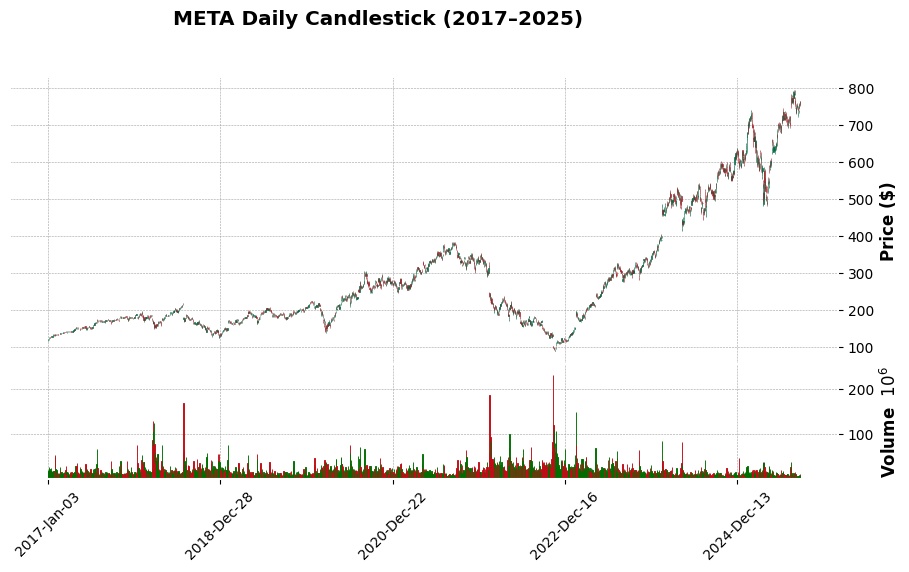

In [4]:
mpf.plot(
    raw,
    type="candle", 
    style="charles",   # clean style
    title="META Daily Candlestick (2017–2025)",
    ylabel="Price ($)",
    volume=True,       # adds volume below chart
    figratio=(12,6)
)

In [5]:
# ----------------------------------------------------------
# 2. Feature engineering
# ----------------------------------------------------------
df["Ret1"]        = df["Close"].pct_change().fillna(0.0)
df["Momentum5"]   = (df["Close"] / df["Close"].shift(5) - 1.0).fillna(0.0)
df["Volatility5"] = df["Ret1"].rolling(5, min_periods=1).std().fillna(0.0)
df["LogVolume"]   = np.log1p(df["Volume"])
df["VIX_Z"]       = (df["VIX_Close"] - df["VIX_Close"].rolling(20, min_periods=1).mean()) / \
                     df["VIX_Close"].rolling(20, min_periods=1).std()
df["VIX_Z"]       = df["VIX_Z"].fillna(0.0)



In [6]:
# ----------------------------------------------------------
# 3. Target = next-day return (Δ target)
# ----------------------------------------------------------
df["TargetRet1"] = (df["Close"].shift(-1) / df["Close"] - 1.0)
df["PrevClose"]  = df["Close"]
df = df.dropna(subset=["TargetRet1"]).copy()



In [7]:
# ----------------------------------------------------------
# 4. Scale features only (not target)
# ----------------------------------------------------------
feature_cols = [
    "Open", "High", "Low", "Close", "Volume",
    "Ret1", "Momentum5", "Volatility5", "LogVolume", "VIX_Z"
]

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df[feature_cols])
scaled_df = pd.DataFrame(scaled_features, columns=feature_cols, index=df.index)

y_all      = df["TargetRet1"].values.astype("float32")
prev_close = df["PrevClose"].values.astype("float32")
dates_all  = df.index

print(f"Scaled features shape: {scaled_df.shape}")



Scaled features shape: (2182, 10)


In [8]:
# ----------------------------------------------------------
# 5. Sequence builder
# ----------------------------------------------------------
def make_sequences(X_df, y, prev_close, dates, window=12):
    X, y_out, prev_c, d_out = [], [], [], []
    for i in range(len(X_df) - window):
        X.append(X_df.iloc[i:i+window].values)
        y_out.append(y[i+window-1])           # predict ΔClose for t+1
        prev_c.append(prev_close[i+window-1]) # previous close
        d_out.append(dates[i+window])         # target date
    return np.array(X), np.array(y_out), np.array(prev_c), np.array(d_out)

window = 12
X, y, prev_c, dts = make_sequences(scaled_df, y_all, prev_close, dates_all, window=window)
split = int(len(X)*0.8)

X_tr, X_te = X[:split], X[split:]
y_tr, y_te = y[:split], y[split:]
pc_tr, pc_te = prev_c[:split], prev_c[split:]
dt_tr, dt_te = dts[:split], dts[split:]

print(f"Train: {X_tr.shape},  Test: {X_te.shape}")



Train: (1736, 12, 10),  Test: (434, 12, 10)


In [9]:
# ----------------------------------------------------------
# 6. Conv1D → LSTM model (CuDNN-safe)
# ----------------------------------------------------------
def build_model(input_shape):
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Conv1D(64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(64, return_sequences=True, unroll=True,
             activation='tanh', recurrent_activation='sigmoid'),
        Dropout(0.1),
        LSTM(32, unroll=True, activation='tanh', recurrent_activation='sigmoid'),
        Dense(32, activation='relu'),
        Dense(1)  # predict next-day return
    ])
    opt = tf.keras.optimizers.Adam(learning_rate=0.002)
    model.compile(optimizer=opt, loss='mse')
    return model

model = build_model((window, X_tr.shape[2]))
es = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)

history = model.fit(
    X_tr, y_tr,
    validation_data=(X_te, y_te),
    epochs=120,
    batch_size=16,
    verbose=1,
    callbacks=[es]
)



'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)


Epoch 1/120


W0000 00:00:1763516550.239955  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516550.258867  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516550.281035  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516550.284303  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516550.288682  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516550.340541  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516550.340693  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516550.343673  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516550.343761  297571 gp

  4/109 [>.............................] - ETA: 4s - loss: 7.3052e-04

W0000 00:00:1763516553.419995  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516553.420065  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516553.420118  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516553.420171  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516553.420234  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516553.420308  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516553.420378  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516553.420447  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516553.420524  297571 gp

109/109 [==============================] - ETA: 0s - loss: 6.5955e-04

W0000 00:00:1763516553.948608  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516553.949015  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516553.949072  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516553.949146  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516553.949224  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516553.949290  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516553.949362  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516553.949424  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516553.949490  297571 gp

109/109 [==============================] - 6s 10ms/step - loss: 6.5955e-04 - val_loss: 5.9064e-04
Epoch 2/120
  1/109 [..............................] - ETA: 0s - loss: 2.5919e-04

W0000 00:00:1763516554.350908  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516554.369078  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516554.369178  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516554.369283  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516554.369380  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516554.369447  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516554.369521  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516554.369593  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516554.369668  297571 gp

109/109 [==============================] - 0s 4ms/step - loss: 6.5063e-04 - val_loss: 5.6716e-04
Epoch 3/120
 11/109 [==>...........................] - ETA: 0s - loss: 4.7258e-04

W0000 00:00:1763516554.855241  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516554.855332  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516554.855385  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516554.855459  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516554.855537  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516554.855603  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516554.855675  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516554.855737  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516554.855803  297571 gp

109/109 [==============================] - 0s 4ms/step - loss: 6.4886e-04 - val_loss: 5.7145e-04
Epoch 4/120
 35/109 [========>.....................] - ETA: 0s - loss: 7.1219e-04

W0000 00:00:1763516555.359495  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516555.360009  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516555.360065  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516555.360119  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516555.360170  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516555.360224  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516555.360297  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516555.360363  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516555.360428  297571 gp

109/109 [==============================] - 0s 4ms/step - loss: 6.5103e-04 - val_loss: 5.6737e-04
Epoch 5/120
 10/109 [=>............................] - ETA: 0s - loss: 6.1955e-04

W0000 00:00:1763516555.769833  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516555.769926  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516555.769975  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516555.770029  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516555.770080  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516555.770132  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516555.770204  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516555.770270  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516555.770334  297571 gp

109/109 [==============================] - 0s 4ms/step - loss: 6.4862e-04 - val_loss: 5.8677e-04
Epoch 6/120
 35/109 [========>.....................] - ETA: 0s - loss: 6.1026e-04

W0000 00:00:1763516556.278946  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516556.279334  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516556.279395  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516556.279446  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516556.279498  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516556.279552  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516556.279625  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516556.279693  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516556.279761  297571 gp

109/109 [==============================] - 0s 4ms/step - loss: 6.5163e-04 - val_loss: 5.7007e-04
Epoch 7/120
 35/109 [========>.....................] - ETA: 0s - loss: 6.5236e-04

W0000 00:00:1763516556.677871  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516556.677955  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516556.678012  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516556.678064  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516556.678114  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516556.678168  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516556.678241  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516556.678309  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516556.678376  297571 gp

109/109 [==============================] - 0s 4ms/step - loss: 6.5178e-04 - val_loss: 5.6743e-04
Epoch 8/120
109/109 [==============================] - 0s 4ms/step - loss: 6.4814e-04 - val_loss: 5.6780e-04
Epoch 9/120
109/109 [==============================] - 0s 4ms/step - loss: 6.5518e-04 - val_loss: 5.7273e-04
Epoch 10/120
109/109 [==============================] - 0s 4ms/step - loss: 6.4999e-04 - val_loss: 5.6736e-04


In [10]:
# ----------------------------------------------------------
# 7. Predict → reconstruct prices
# ----------------------------------------------------------
y_pred_ret = model.predict(X_te).flatten()
y_pred_price = pc_te * (1.0 + y_pred_ret)
y_true_price = pc_te * (1.0 + y_te)

# ----------------------------------------------------------
# 8. Metrics
# ----------------------------------------------------------
mape = np.mean(np.abs((y_true_price - y_pred_price) / y_true_price)) * 100
mae  = mean_absolute_error(y_true_price, y_pred_price)
rmse = mean_squared_error(y_true_price, y_pred_price, squared=False)
r2   = r2_score(y_true_price, y_pred_price)

print(f"MAPE={mape:.2f}% | MAE=${mae:.2f} | RMSE=${rmse:.2f} | R²={r2:.3f}")



14/14 [==============================] - 0s 6ms/step
MAPE=1.55% | MAE=$8.67 | RMSE=$12.90 | R²=0.985


W0000 00:00:1763516558.689775  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516558.689875  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516558.689931  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516558.690001  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516558.690086  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516558.690149  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516558.690220  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516558.690288  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516558.690356  297571 gp

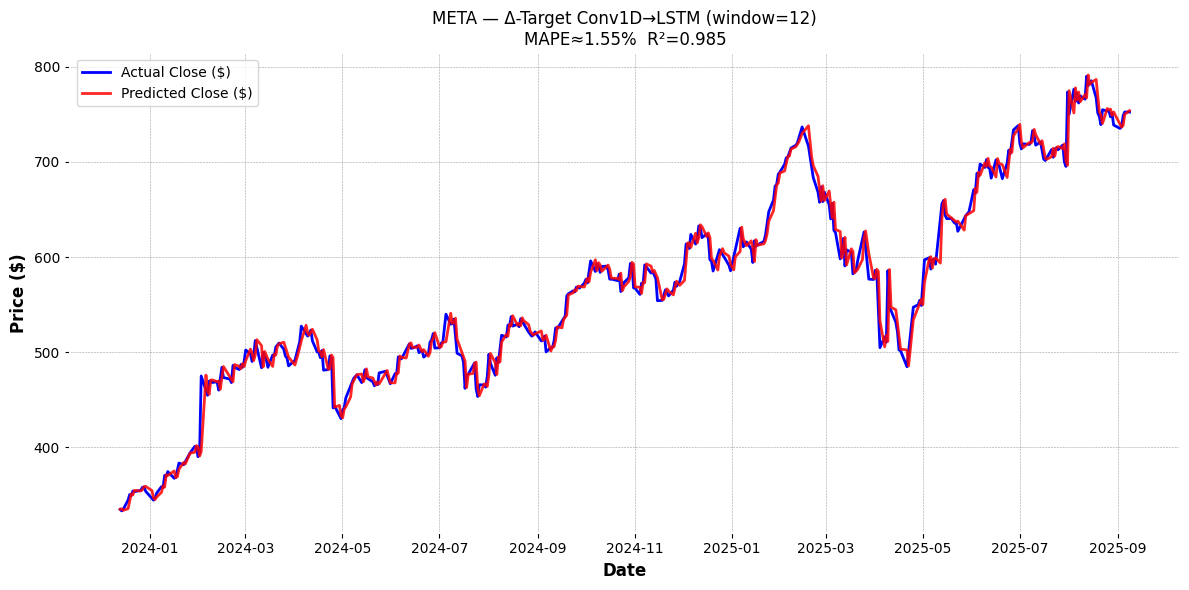

In [11]:
# ----------------------------------------------------------
# 8. Plot results
# ----------------------------------------------------------
plt.figure(figsize=(12,6))
plt.plot(dt_te, y_true_price, label="Actual Close ($)", color="blue")
plt.plot(dt_te, y_pred_price, label="Predicted Close ($)", color="red", alpha=0.85)
plt.title(f"META — Δ-Target Conv1D→LSTM (window={window})\nMAPE≈{mape:.2f}%  R²={r2:.3f}")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [12]:
# 9. Save model + scaler
# ----------------------------------------------------------
os.makedirs("models", exist_ok=True)
model.save("models/META_stage1_v26.h5")
joblib.dump(scaler, "models/META_scaler_v26.pkl")
print("Model & scaler saved to ./models/")

Model & scaler saved to ./models/


/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### Stage 2

W0000 00:00:1763516559.598652  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516559.598747  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516559.598801  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516559.598879  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516559.598966  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516559.599032  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516559.599102  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516559.599174  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516559.599241  297571 gp

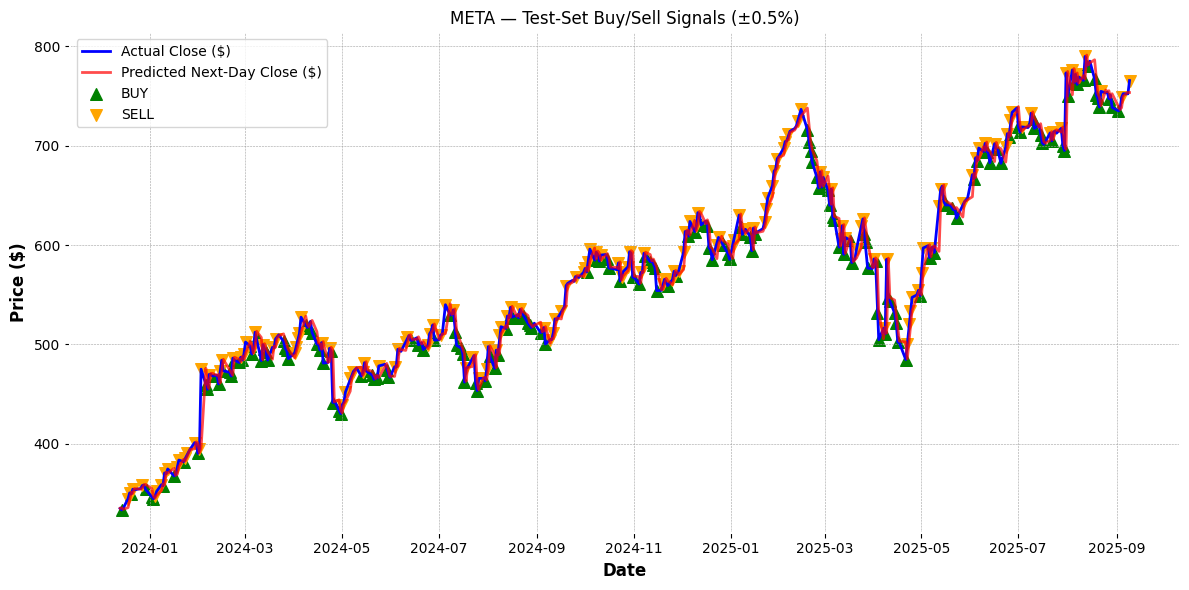

=== TEST-SET RESULTS ===
Strategy  → CAGR -81.50%, Vol 19.85%, Sharpe -4.10
Buy&Hold → CAGR 61.65%, Vol 37.82%, Sharpe 1.63


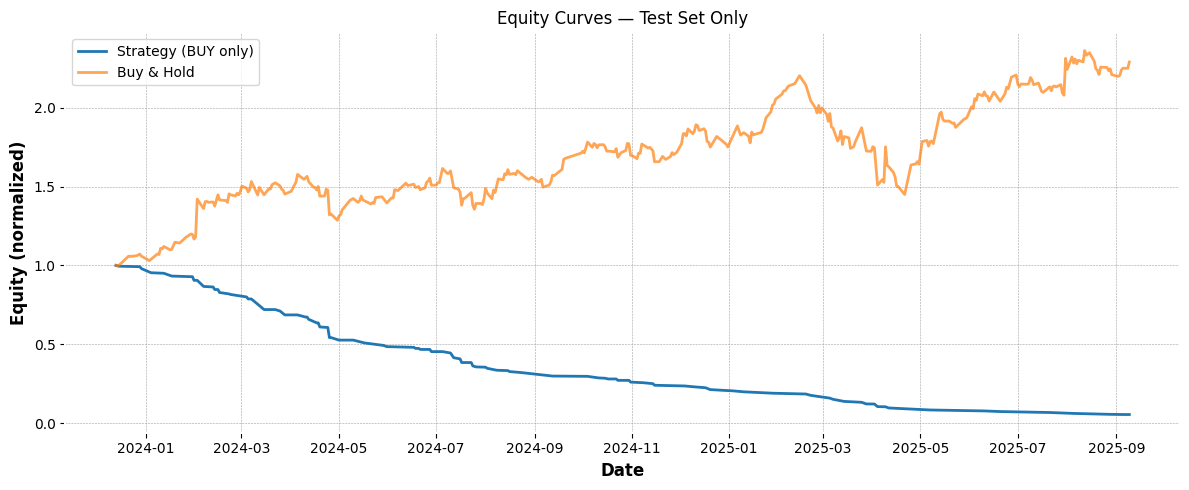


Recent test-period signals:
                               Actual   Predicted    Gap(%) Signal
2025-08-26 04:00:00+00:00  754.099976  754.636486  0.071146   HOLD
2025-08-27 04:00:00+00:00  747.380005  755.433129  1.077514    BUY
2025-08-28 04:00:00+00:00  751.109985  748.699764 -0.320888   HOLD
2025-08-29 04:00:00+00:00  738.700012  752.434361  1.859259    BUY
2025-09-02 04:00:00+00:00  735.109985  740.004267  0.665789    BUY
2025-09-03 04:00:00+00:00  737.049988  736.410005 -0.086830   HOLD
2025-09-04 04:00:00+00:00  748.650024  738.354844 -1.375166   SELL
2025-09-05 04:00:00+00:00  752.450012  749.982646 -0.327911   HOLD
2025-09-08 04:00:00+00:00  752.299988  753.788053  0.197802   HOLD
2025-09-09 04:00:00+00:00  765.700012  753.634174 -1.575792   SELL
Saved: artifacts/stage2_signals_META.csv
Saved: models/stage2_config_META.pkl
Saved placeholder model: models/stage2_direct_signal_placeholder_META.h5


/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [13]:
# ==========================================================
#  Stage 2 (Direct Signal, Test Only)
#  v2.4 — Plot & Backtest only on Stage-1 test split
# ==========================================================




# ----------------------------
# Config
# ----------------------------
TICKER = "META"
#START, END = "2017-01-01", "2025-09-10"
WINDOW = 12
THRESH = 0.005   # 0.5% price gap threshold for Buy/Sell
TEST_RATIO = 0.2


# ----------------------------
# Load price data (META + VIX)
# ----------------------------
voo = yf.Ticker(TICKER).history(start=start_date, end=end_date, auto_adjust=False)
vix = yf.Ticker("^VIX").history(start=start_date, end=end_date, auto_adjust=False)
voo = voo[["Open","High","Low","Close","Volume"]].dropna()
vix = vix[["Close"]].rename(columns={"Close":"VIX_Close"}).dropna()

df = voo.join(vix, how="outer").sort_index()
df["VIX_Close"] = df["VIX_Close"].ffill()
df = df.dropna(subset=["Open","High","Low","Close","Volume"]).copy()

# ----------------------------
# Load Stage-1 model + scaler
# ----------------------------
model_path = "models/META_stage1_v26.h5"
scaler_path = "models/META_scaler_v26.pkl"
assert os.path.exists(model_path), "Stage-1 model not found!"
assert os.path.exists(scaler_path), "Stage-1 scaler not found!"

model = tf.keras.models.load_model(model_path, compile=False)
scaler = joblib.load(scaler_path)

# ----------------------------
# Feature engineering (same schema)
# ----------------------------
df["Ret1"]        = df["Close"].pct_change().fillna(0.0)
df["Momentum5"]   = (df["Close"]/df["Close"].shift(5)-1.0).fillna(0.0)
df["Volatility5"] = df["Ret1"].rolling(5,1).std().fillna(0.0)
df["LogVolume"]   = np.log1p(df["Volume"])
df["VIX_Z"] = (df["VIX_Close"] - df["VIX_Close"].rolling(20,1).mean()) / df["VIX_Close"].rolling(20,1).std()
df["VIX_Z"] = df["VIX_Z"].fillna(0.0)

feature_cols = [
    "Open","High","Low","Close","Volume",
    "Ret1","Momentum5","Volatility5","LogVolume","VIX_Z"
]
scaled = scaler.transform(df[feature_cols])
scaled_df = pd.DataFrame(scaled, columns=feature_cols, index=df.index)

# ----------------------------
# Build rolling input windows
# ----------------------------
def make_seq(Xdf, window=WINDOW):
    Xs, dates = [], []
    for i in range(len(Xdf)-window):
        Xs.append(Xdf.iloc[i:i+window].values)
        dates.append(Xdf.index[i+window])
    return np.array(Xs), np.array(dates)

Xseq, dates = make_seq(scaled_df, window=WINDOW)
pred_ret = model.predict(Xseq, verbose=0).flatten()

# ----------------------------
# Reconstruct predicted prices
# ----------------------------
close_vals = df["Close"].values
pred_price = close_vals[WINDOW-1:-1] * (1 + pred_ret)
actual_price = close_vals[WINDOW:]
dates = np.array(dates)

# ----------------------------
# Split train/test (chronological)
# ----------------------------
split_idx = int(len(pred_price)*(1-TEST_RATIO))
pred_price_test = pred_price[split_idx:]
actual_price_test = actual_price[split_idx:]
dates_test = dates[split_idx:]

# ----------------------------
# Generate BUY / SELL / HOLD on test only
# ----------------------------
gap = (pred_price_test - actual_price_test) / actual_price_test
signals = np.zeros_like(pred_price_test)
signals[gap > THRESH]  = 1    # BUY
signals[gap < -THRESH] = -1   # SELL
signal_labels = np.where(signals==1,"BUY",np.where(signals==-1,"SELL","HOLD"))

df_signals = pd.DataFrame({
    "Actual": actual_price_test,
    "Predicted": pred_price_test,
    "Gap(%)": gap*100,
    "Signal": signal_labels
}, index=dates_test)

# ----------------------------
# Plot (TEST only)
# ----------------------------
plt.figure(figsize=(12,6))
plt.plot(df_signals.index, df_signals["Actual"], label="Actual Close ($)", color="blue")
plt.plot(df_signals.index, df_signals["Predicted"], label="Predicted Next-Day Close ($)", color="red", alpha=0.7)
plt.scatter(df_signals.index[df_signals["Signal"]=="BUY"], df_signals["Actual"][df_signals["Signal"]=="BUY"], 
            marker="^", color="green", label="BUY", s=70)
plt.scatter(df_signals.index[df_signals["Signal"]=="SELL"], df_signals["Actual"][df_signals["Signal"]=="SELL"], 
            marker="v", color="orange", label="SELL", s=70)
plt.title(f"{TICKER} — Test-Set Buy/Sell Signals (±{THRESH*100:.1f}%)")
plt.xlabel("Date"); plt.ylabel("Price ($)")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()

# ----------------------------
# Simple backtest (TEST only)
# ----------------------------
returns = pd.Series(df["Close"]).pct_change().reindex(df_signals.index).fillna(0)
positions = np.where(df_signals["Signal"]=="BUY", 1.0, 0.0)
strategy_returns = returns * positions
eq_curve = (1 + strategy_returns).cumprod()
bh_curve = (1 + returns).cumprod()

def ann_metrics(r):
    cagr = (1.0 + r).prod() ** (252/len(r)) - 1.0
    vol  = r.std() * np.sqrt(252)
    sharpe = cagr/vol if vol>0 else 0
    return cagr, vol, sharpe

cagr_s, vol_s, sh_s = ann_metrics(strategy_returns)
cagr_b, vol_b, sh_b = ann_metrics(returns)

print(f"=== TEST-SET RESULTS ===")
print(f"Strategy  → CAGR {cagr_s:.2%}, Vol {vol_s:.2%}, Sharpe {sh_s:.2f}")
print(f"Buy&Hold → CAGR {cagr_b:.2%}, Vol {vol_b:.2%}, Sharpe {sh_b:.2f}")

plt.figure(figsize=(12,5))
plt.plot(eq_curve.index, eq_curve.values, label="Strategy (BUY only)")
plt.plot(bh_curve.index, bh_curve.values, label="Buy & Hold", alpha=0.7)
plt.title("Equity Curves — Test Set Only")
plt.xlabel("Date"); plt.ylabel("Equity (normalized)")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()

print("\nRecent test-period signals:")
print(df_signals.tail(10))


os.makedirs("models", exist_ok=True)
os.makedirs("artifacts", exist_ok=True)

# 1 Save signal dataframe (test predictions)
df_signals.to_csv("artifacts/stage2_signals_META.csv")
print("Saved: artifacts/stage2_signals_META.csv")

# 2 Save the rule parameters as a tiny dict (so we can reload later)
stage2_config = {
    "ticker": TICKER,
    "window": WINDOW,
    "threshold": THRESH,
    "test_ratio": TEST_RATIO,
    "feature_cols": feature_cols,
    "metrics": {
        "strategy_cagr": float(cagr_s),
        "strategy_vol":  float(vol_s),
        "strategy_sharpe": float(sh_s)
    }
}
joblib.dump(stage2_config, "models/stage2_config_META.pkl")
print("Saved: models/stage2_config_META.pkl")

# 3 Optional: save a lightweight “direct-signal model” placeholder
# (just to mark this stage so ensemble loader can find it)
placeholder = Sequential([Dense(1, input_shape=(1,))])
placeholder.save("models/stage2_direct_signal_placeholder_META.h5")
print("Saved placeholder model: models/stage2_direct_signal_placeholder_META.h5")



In [14]:
# ==========================================================
#  Stage 2 — CNN + SVM Training and Save
# ==========================================================

# ----------------------------
# Config
# ----------------------------

#START, END = "2017-01-01", "2025-09-10"
WINDOW = 7
EPOCHS, BATCH = 40, 32
os.makedirs("models", exist_ok=True)

# ----------------------------
# Load META + VIX
# ----------------------------
voo = yf.Ticker(TICKER).history(start=start_date, end=end_date, auto_adjust=False)
vix = yf.Ticker("^VIX").history(start=start_date, end=end_date, auto_adjust=False)
df = voo.join(vix[["Close"]].rename(columns={"Close":"VIX_Close"}), how="outer")
df["VIX_Close"] = df["VIX_Close"].ffill()
df = df[["Open","High","Low","Close","Volume","VIX_Close"]].dropna()

# ----------------------------
# Feature engineering
# ----------------------------
df["Ret1"]        = df["Close"].pct_change().fillna(0.0)
df["Momentum5"]   = (df["Close"]/df["Close"].shift(5)-1.0).fillna(0.0)
df["Volatility5"] = df["Ret1"].rolling(5,1).std().fillna(0.0)
df["LogVolume"]   = np.log1p(df["Volume"])
df["VIX_Z"]       = (df["VIX_Close"]-df["VIX_Close"].rolling(20,1).mean())/df["VIX_Close"].rolling(20,1).std()
df["VIX_Z"]       = df["VIX_Z"].fillna(0.0)

features = ["Open","High","Low","Close","Volume","Ret1","Momentum5",
            "Volatility5","LogVolume","VIX_Z"]
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[features])
scaled_df = pd.DataFrame(scaled, columns=features, index=df.index)

# ----------------------------
# Build CNN “images” and labels
# ----------------------------
def make_seq(df_scaled, horizon=1, window=WINDOW):
    X, y = [], []
    closes = df["Close"].values
    for i in range(len(df_scaled)-window-horizon):
        X.append(df_scaled.iloc[i:i+window].values.T)
        fwd_ret = (closes[i+window+horizon-1]-closes[i+window-1]) / closes[i+window-1]
        y.append(1 if fwd_ret>0 else 0)  # 1=Up, 0=Down
    return np.array(X), np.array(y)

X, y = make_seq(scaled_df)
X = X[..., np.newaxis]
print("Dataset:", X.shape, y.shape)

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, shuffle=False)

# ----------------------------
# CNN model
# ----------------------------
inp = Input(shape=(X.shape[1], X.shape[2], 1))
x = Conv2D(32, (3,3), padding="same", activation="relu")(inp)
x = BatchNormalization()(x)
x = MaxPooling2D((1,2))(x)
x = Conv2D(64, (3,3), padding="same", activation="relu")(x)
x = BatchNormalization()(x)
x = MaxPooling2D((1,2))(x)
x = Flatten()(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.3)(x)
out = Dense(2, activation="softmax")(x)

cnn = Model(inp, out)
cnn.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"])
es = EarlyStopping(monitor="val_accuracy", patience=6, restore_best_weights=True)
cnn.fit(Xtr, ytr, validation_data=(Xte, yte),
        epochs=EPOCHS, batch_size=BATCH, callbacks=[es], verbose=1)

cnn.save("models/stage2_cnn_META.h5")
print("Saved: models/stage2_cnn_META.h5")

# ----------------------------
# SVM on CNN embeddings
# ----------------------------
embed_model = Model(inputs=cnn.input, outputs=cnn.layers[-3].output)
emb_tr = embed_model.predict(Xtr, verbose=0)
emb_te = embed_model.predict(Xte, verbose=0)

svm = SVC(kernel="rbf", probability=True)
svm.fit(emb_tr, ytr)
acc = svm.score(emb_te, yte)
print(f"SVM accuracy: {acc:.3f}")
joblib.dump(svm, "models/stage2_svm_META.pkl")
print("Saved: models/stage2_svm_META.pkl")


Dataset: (2174, 10, 7, 1) (2174,)
Epoch 1/40


W0000 00:00:1763516561.367252  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516561.368105  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516561.372335  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516561.372435  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516561.372508  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516561.372585  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516561.372649  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516561.372754  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516561.399275  297571 gp

13/55 [======>.......................] - ETA: 0s - loss: 1.3352 - accuracy: 0.4784

'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
W0000 00:00:1763516562.112542  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516562.112801  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516562.112877  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516562.112967  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516562.113035  297571 gpu_timer.cc:114] Skipping the delay kernel, measu

55/55 [==============================] - ETA: 0s - loss: 0.8726 - accuracy: 0.5049

W0000 00:00:1763516562.333489  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516562.333580  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516562.333637  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516562.333706  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516562.333770  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516562.333863  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516562.333937  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516562.334019  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516562.334097  297571 gp

55/55 [==============================] - 2s 9ms/step - loss: 0.8726 - accuracy: 0.5049 - val_loss: 0.6986 - val_accuracy: 0.4644
Epoch 2/40
38/55 [===================>..........] - ETA: 0s - loss: 0.6912 - accuracy: 0.5280

W0000 00:00:1763516562.583180  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516562.583268  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516562.583325  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516562.583397  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516562.583460  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516562.583547  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516562.583621  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516562.583709  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516562.583791  297571 gp

55/55 [==============================] - 0s 5ms/step - loss: 0.6920 - accuracy: 0.5267 - val_loss: 0.7144 - val_accuracy: 0.4644
Epoch 3/40
35/55 [==================>...........] - ETA: 0s - loss: 0.6876 - accuracy: 0.5348

W0000 00:00:1763516562.807581  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516562.807674  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516562.807732  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516562.807801  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516562.807874  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516562.807965  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516562.808039  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516562.808121  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516562.808200  297571 gp

55/55 [==============================] - 0s 4ms/step - loss: 0.6930 - accuracy: 0.5135 - val_loss: 0.7352 - val_accuracy: 0.4644
Epoch 4/40
55/55 [==============================] - 0s 3ms/step - loss: 0.6933 - accuracy: 0.5095 - val_loss: 0.7458 - val_accuracy: 0.4644
Epoch 5/40
55/55 [==============================] - 0s 3ms/step - loss: 0.6917 - accuracy: 0.5141 - val_loss: 0.7559 - val_accuracy: 0.4644
Epoch 6/40
55/55 [==============================] - 0s 3ms/step - loss: 0.6931 - accuracy: 0.5118 - val_loss: 0.7430 - val_accuracy: 0.4644
Epoch 7/40
55/55 [==============================] - 0s 3ms/step - loss: 0.6921 - accuracy: 0.5198 - val_loss: 0.7342 - val_accuracy: 0.4667
Epoch 8/40
55/55 [==============================] - 0s 3ms/step - loss: 0.6916 - accuracy: 0.5221 - val_loss: 0.8102 - val_accuracy: 0.4621
Epoch 9/40
55/55 [==============================] - 0s 4ms/step - loss: 0.6965 - accuracy: 0.5204 - val_loss: 0.8650 - val_accuracy: 0.5149
Epoch 10/40
55/55 [============

/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


SVM accuracy: 0.529
Saved: models/stage2_svm_META.pkl


### Stage 3

In [15]:

#  Predict next-day open and close price + signal
#  Interactive Jupyter version

# ----------------------------
# Config
# ----------------------------
VIX = "^VIX"
WINDOW_LSTM = 12
WINDOW_CNN = 7
THRESH = 0.02  # 2% threshold for signal
LOOKBACK = 200  # days before target date for context

# ----------------------------
# Ask user inputs
# ----------------------------
ticker = input("Enter stock ticker (e.g., VOO, AAPL, MSFT): ").strip().upper()
while True:
    date_str = input("Enter date (YYYY-MM-DD): ").strip()
    try:
        target_date = datetime.strptime(date_str, "%Y-%m-%d")
        break
    except ValueError:
        print("Invalid format. Please use YYYY-MM-DD (e.g., 2025-11-06).")

# ----------------------------
# Load models
# ----------------------------
stage1_path = "models/META_stage1_v26.h5"
scaler_path = "models/META_scaler_v26.pkl"
cnn_path = "models/stage2_cnn_META.h5"
svm_path = "models/stage2_svm_META.pkl"

assert os.path.exists(stage1_path), "Missing Stage 1 model"
assert os.path.exists(scaler_path), "Missing Stage 1 scaler"
model_stage1 = tf.keras.models.load_model(stage1_path, compile=False)
scaler = joblib.load(scaler_path)

cnn_model, svm = None, None
if os.path.exists(cnn_path) and os.path.exists(svm_path):
    cnn_model = tf.keras.models.load_model(cnn_path, compile=False)
    svm = joblib.load(svm_path)

# ----------------------------
# Load price data
# ----------------------------
start_date = (target_date - timedelta(days=LOOKBACK)).strftime("%Y-%m-%d")
end_date = (target_date + timedelta(days=1)).strftime("%Y-%m-%d")

print(f"Fetching {ticker} and VIX data up to {target_date.date()}...")
stock = yf.Ticker(ticker).history(start=start_date, end=end_date, auto_adjust=False)
vix = yf.Ticker(VIX).history(start=start_date, end=end_date, auto_adjust=False)

if stock.empty:
    raise ValueError(f"No data found for {ticker}. Check the ticker symbol.")

df = stock.join(vix[["Close"]].rename(columns={"Close": "VIX_Close"}), how="outer")
df["VIX_Close"] = df["VIX_Close"].ffill()
df = df.dropna(subset=["Open", "High", "Low", "Close", "Volume"])

# ----------------------------
# Feature engineering
# ----------------------------
df["Ret1"] = df["Close"].pct_change().fillna(0.0)
df["Momentum5"] = (df["Close"] / df["Close"].shift(5) - 1.0).fillna(0.0)
df["Volatility5"] = df["Ret1"].rolling(5, 1).std().fillna(0.0)
df["LogVolume"] = np.log1p(df["Volume"])
df["VIX_Z"] = (df["VIX_Close"] - df["VIX_Close"].rolling(20, 1).mean()) / df["VIX_Close"].rolling(20, 1).std()
df["VIX_Z"] = df["VIX_Z"].fillna(0.0)

feature_cols = [
    "Open", "High", "Low", "Close", "Volume",
    "Ret1", "Momentum5", "Volatility5", "LogVolume", "VIX_Z"
]

scaled = scaler.transform(df[feature_cols])
scaled_df = pd.DataFrame(scaled, columns=feature_cols, index=df.index)

# ----------------------------
# Stage 1 — LSTM price predictions (Open + Close)
# ----------------------------
X_last = scaled_df.iloc[-WINDOW_LSTM:].values.reshape(1, WINDOW_LSTM, -1)

# predict close
pred_ret_close = model_stage1.predict(X_last, verbose=0).flatten()[0]
pred_close_price = df["Close"].iloc[-1] * (1 + pred_ret_close)

# predict open (shift features by 1 day to simulate next open)
X_last_shifted = scaled_df.iloc[-(WINDOW_LSTM+1):-1].values.reshape(1, WINDOW_LSTM, -1)
pred_ret_open = model_stage1.predict(X_last_shifted, verbose=0).flatten()[0]
pred_open_price = df["Open"].iloc[-1] * (1 + pred_ret_open)

print(f"Stage 1 predicts:")
print(f"   → Next Open ≈ ${pred_open_price:.2f} ({pred_ret_open*100:.3f}% change)")
print(f"   → Next Close ≈ ${pred_close_price:.2f} ({pred_ret_close*100:.3f}% change)")

# ----------------------------
# Stage 2 — CNN + SVM direction signal (if available)
# ----------------------------
stage2_signal, cnn_conf = 0, 0.0
if cnn_model and svm:
    cnn_input = scaled_df.iloc[-WINDOW_CNN:].values.T.reshape(1, len(feature_cols), WINDOW_CNN, 1)

    cnn_embed_model = tf.keras.Model(inputs=cnn_model.input, outputs=cnn_model.layers[-3].output)
    cnn_embed = cnn_embed_model.predict(cnn_input, verbose=0)

    cnn_logits = cnn_model.predict(cnn_input, verbose=0)
    cnn_pred = np.argmax(cnn_logits, axis=1)[0]
    cnn_conf = cnn_logits[0][cnn_pred]

    stage2_signal = svm.predict(cnn_embed)[0]
    stage2_signal = 1 if stage2_signal == 1 else -1
    print(f"Stage 2 predicts: {'BUY' if stage2_signal==1 else 'SELL'} (conf={cnn_conf:.2f})")
else:
    print("Stage 2 not available — using Stage 1 only.")

# ----------------------------
# Combine predictions → Final Signal
# ----------------------------
if stage2_signal == 1 and pred_ret_close > THRESH:
    action = "BUY"
elif stage2_signal == -1 and pred_ret_close < -THRESH:
    action = "SELL"
elif abs(pred_ret_close) < THRESH / 2:
    action = "HOLD"
else:
    action = "BUY" if pred_ret_close > 0 else "SELL"




Enter stock ticker (e.g., VOO, AAPL, MSFT):  META
Enter date (YYYY-MM-DD):  2025-11-02


Fetching META and VIX data up to 2025-11-02...


W0000 00:00:1763516577.948996  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516577.949090  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516577.949147  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516577.949223  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516577.949311  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516577.949376  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516577.949448  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516577.949522  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516577.949594  297571 gp

Stage 1 predicts:
   → Next Open ≈ $675.72 (0.179% change)
   → Next Close ≈ $649.52 (0.180% change)
Stage 2 predicts: BUY (conf=1.00)


W0000 00:00:1763516578.265599  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516578.265697  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516578.265757  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516578.265837  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516578.265900  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516578.265987  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516578.266061  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516578.266149  297571 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1763516578.266227  297571 gp

In [16]:
# ----------------------------
# Display final result
# ----------------------------
print("\nFINAL PREDICTION RESULT")
print(f"Ticker: {ticker}")
print(f"Date: {target_date.strftime('%Y-%m-%d')}")
print(f"Latest available close: ${df['Close'].iloc[-1]:.2f}")
print(f"Predicted next OPEN: ${pred_open_price:.2f}")
print(f"Predicted next CLOSE: ${pred_close_price:.2f}")
print(f"Predicted return: {pred_ret_close*100:.3f}%")
print(f"Signal: {'BUY' if action=='BUY' else ('SELL' if action=='SELL' else 'HOLD')}")


FINAL PREDICTION RESULT
Ticker: META
Date: 2025-11-02
Latest available close: $648.35
Predicted next OPEN: $675.72
Predicted next CLOSE: $649.52
Predicted return: 0.180%
Signal: HOLD
